In [65]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [66]:
# We’ll need a unique index per word to use as the inputs and targets of the networks later.
# To keep track of all this we will use a helper class called Lang which has word → index (word2index) and 
# index → word (index2word) dictionaries, as well as a count of each word word2count to use to later replace rare words.
#




SOS_token = 0
EOS_token = 1
MAX_LENGTH = 500
class Lang: 
    def __init__(self, name):
        self.name = name
        self.word2index = {} 
        self.word2count = {}
        self.index2word = {0: "SOS" , 1: "EOS"}
        self.n_words = 2  # count SOS and EOS 
        
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
        
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1 
            self.index2word[self.n_words] = word
            self.n_words += 1
            
        else:
            self.word2count[word] += 1
            

In [67]:
# turn Unicode characters to ASCII
# make lowercase and remove punctuation 


# Turn Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


# lowercase, trim, remove non-letter chars

def normalizeString(s):
   # s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([!?])", r" \1", s)
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
  #  s = re.sub(r"[1-9]+",)
    return s

In [68]:
# To read data file, split into lines 
# then split lines into pairs
# add reverse flag to swtich from ENG-Khm to Khm-eng

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('khm.txt', encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs
    

In [69]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'khmer', True)
print(random.choice(pairs))

Reading lines...
Read 462 sentence pairs
Trimmed to 462 sentence pairs
Counting words...
Counted words:
khmer 1042
eng 1386
['តើខ្ញុំអាចជួយអីបានទេ  ?', 'Can I help you ?']


In [70]:
# Recurrent Neural Network, or RNN, is a network that operates on a sequence and uses its own output as input for subsequent step
# A Sequence to Sequence network, or seq2seq network, or Encoder Decoder network, is a model consisting of two RNNs called the 
# encoder and decoder
# The encoder reads an input sequence and outputs a single vector
# the decoder reads that vector to produce an output sequence


#-------------- Encoder 

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
            


In [71]:
# Decoder is another RNN that takes the encoder output vectors and outputs sequence of words for translation
# This is a simple seq2seq decoder, meaning only last output of encoder. (called context vector)
# context vector used as initial hidden state of decoder
# every step of decoding, decoder is given input token and hidden state
# Initial toekn is start-of-string <SOS> 
# first hidden state is context vector 



class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [72]:
# Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs
# first calculate a set of attention weights
# the result (attn_applied) should contain info about specific parts of the input sequence,
# which helps the encoder choose the right output words

# calculating the attention weights is done with another feed-forward layer (attn)
# we have to create max sentence length because there are sentences of all different lenghts.

class AttnDecoderRNN(nn.Module):
    
    
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [73]:
#To train, for each pair we will need an input tensor (indexes of the words in the input sentence) 
# and target tensor (indexes of the words in the target sentence). 
# While creating these vectors we will append the EOS token to both sequences.


def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


In [74]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length



In [75]:
# This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.

import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [76]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [77]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [78]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [79]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

3m 44s (- 11m 12s) (5000 25%) 3.1616
7m 59s (- 7m 59s) (10000 50%) 1.2501
12m 29s (- 4m 9s) (15000 75%) 0.4012
17m 8s (- 0m 0s) (20000 100%) 0.3122


<Figure size 432x288 with 0 Axes>

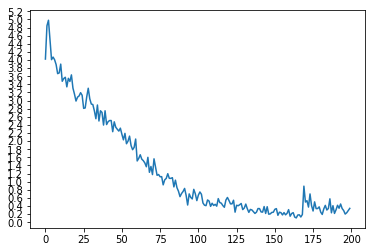

In [94]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 20000, print_every=5000)

In [98]:
evaluateRandomly(encoder1, attn_decoder1)

> នរណាចង់ម៉ោ នាំម៉ោក៏បានដែរ ។
= You may bring whoever wants to come.
< You may bring whoever wants to come. <EOS>

> Goat yiəy peam pʰiəsaa.
= He speaks five languages.
< He speaks five languages. <EOS>

> ប្រហែលជាគាត់ជិះរថភ្លើងជើងក្រោយ ។
= He may be on the next train.
< He may be on the next train. <EOS>

> ឱ្យខ្ញុំនៅម្នាក់់ឯង  !
= Leave me alone !
< Leave me alone ! <EOS>

> ខ្ញុំមិនមានបំណង ធ្វើឱ្យ ថមអាម៉ាស់មុខទេ។
= I didn't want to humiliate Tom.
< I didn't want to humiliate Tom. <EOS>

> នាងបានកំពុងឈរសំឡឹងទៅកាន់សមុទ្រ។
= She stood looking out toward the sea.
< She stood looking out toward the sea. <EOS>

> សូមចាំបន្តិច ។
= Please wait a moment.
< Please wait a moment. <EOS>

> លឿនឡើង ។
= Hurry up.
< Hurry up. <EOS>

> ថម នៅជាមួយ ម៉ារី ។
= Tom is with Mary.
< Tom is with Mary. <EOS>

> ខ្ញុំញ៉ាំនំប៉័ង។
= I eat bread.
< I eat bread. <EOS>



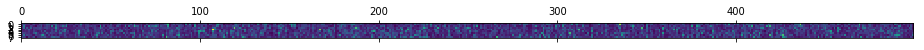

In [99]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "ម្សិលមិញ នាងបង្កើតបានកូនស្រីម្នាក់ ។")
plt.matshow(attentions.numpy())

input = របស់សិល្បករជាសារ តាមរយៈពាក្យពេចន៍របស់ ឆេង ភុន
output = I got a question. <EOS>
input = ខ្ញុំបានគិតថា ខ្ញុំបានឮសំឡេងអ្វីមួយនៅខាងក្រៅ។
output = I thought I heard something outside. <EOS>
input = ខ្ញុំគិតថាវានៅកន្លែងណាមួយក្បែរៗនេះ។
output = I think it's somewhere around here. <EOS>


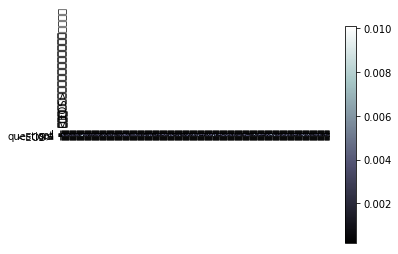

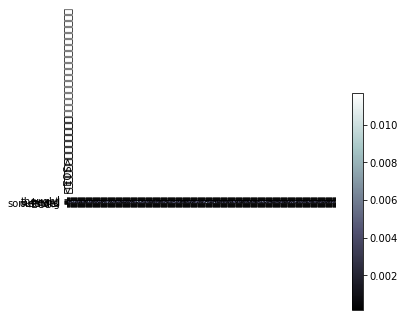

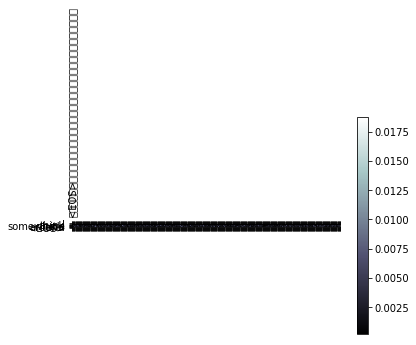

In [101]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("របស់សិល្បករជាសារ តាមរយៈពាក្យពេចន៍របស់ ឆេង ភុន")

evaluateAndShowAttention("ខ្ញុំបានគិតថា ខ្ញុំបានឮសំឡេងអ្វីមួយនៅខាងក្រៅ។")

evaluateAndShowAttention("ខ្ញុំគិតថាវានៅកន្លែងណាមួយក្បែរៗនេះ។")

